In [55]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
import torch

from torch import nn
from torch.utils.data import  DataLoader, TensorDataset
from sklearn.metrics import  accuracy_score, f1_score, confusion_matrix

import seaborn as sns
from xgboost import XGBClassifier

np.random.seed(42)
torch.manual_seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [56]:
raw_dataset = pd.read_csv('raw_merged_heart_dataset.csv')

len(raw_dataset)

2181

In [57]:
raw_dataset.duplicated().sum()

1287

In [58]:

for i in raw_dataset.columns:
    if raw_dataset[i].dtype == 'object':
        print(i)
        raw_dataset[i] = pd.to_numeric(raw_dataset[i], downcast='integer', errors='coerce')

# raw_dataset.info()

trestbps
chol
fbs
restecg
thalachh
exang
slope
ca
thal


In [59]:
raw_dataset_ = raw_dataset.drop_duplicates(inplace=False)
len(raw_dataset_), len(raw_dataset)

(894, 2181)

In [60]:
pd.concat([raw_dataset_.nunique(), raw_dataset_.dtypes, raw_dataset_.isna().sum()],axis=1)

,0,1,2
age,47,int64,0
sex,2,int64,0
cp,5,int64,0
trestbps,54,float64,1
chol,201,float64,22
fbs,2,float64,8
restecg,3,float64,1
thalachh,103,float64,1
exang,2,float64,1
oldpeak,41,float64,0


age 47
sex 2
cp 5
trestbps 54
chol 201
fbs 2
restecg 3
thalachh 103
exang 2
oldpeak 41
slope 4
ca 5
thal 6


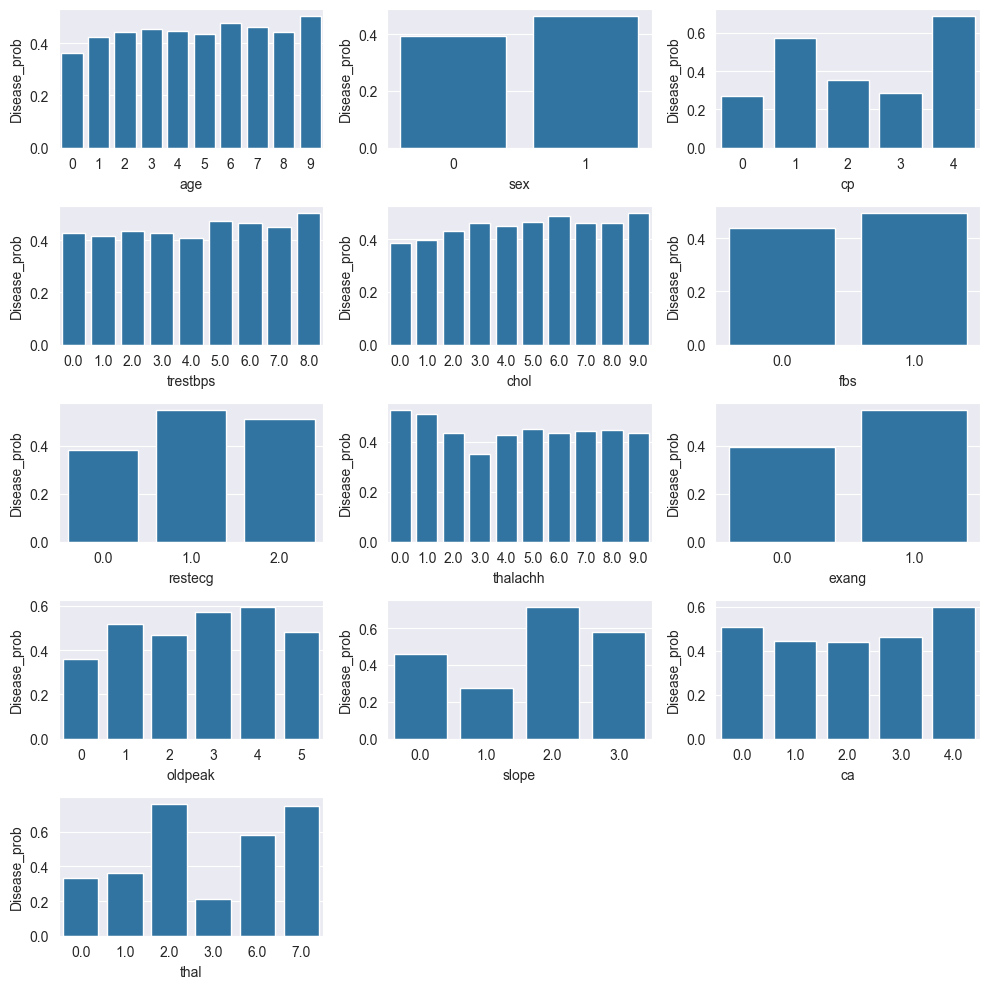

In [61]:
def plot_proba(df_ : pd.DataFrame, qcut = 10): # ploting probability to target = 1, independent of features values
    df = df_.copy()

    cols = df.drop(columns = ["target"]).columns

    ncols = 3
    nrows = np.ceil(len(cols)/ncols).astype(int)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))
    ax = ax.ravel()
    j = 0

    for col in cols:
        print(col, df[col].nunique())
        if df[col].nunique() >40 :
            df[col] = pd.qcut(df[col], qcut, labels=False, duplicates='drop')

        df_agg = df.groupby(col).agg(
            Disease_prob = ("target", "mean")
        )

        sns.barplot(x = col, y = "Disease_prob", data = df_agg, ax = ax[j] )
        j+=1

    while j<ncols*nrows:
        ax[j].remove()
        j+=1

    plt.tight_layout()
    plt.show()


plot_proba(raw_dataset_)
# plot_proba(raw_dataset.fillna(0))

In [62]:
raw_dataset_.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.079294,-0.085903,0.242561,0.152705,0.157099,0.138413,-0.305579,0.138534,0.245134,-0.049422,0.326633,0.024821,0.061686
sex,-0.079294,1.000000,0.052705,-0.014337,-0.116143,0.032172,-0.036036,-0.088777,0.144034,0.101472,0.017718,0.083599,0.201385,0.068153
cp,-0.085903,0.052705,1.000000,0.029835,0.047891,-0.019341,0.083308,-0.135372,0.057105,-0.016416,0.268841,-0.033161,0.546983,0.224668
trestbps,0.242561,-0.014337,0.029835,1.000000,0.117430,0.141215,0.006683,-0.091657,0.109597,0.193527,0.027794,0.087726,0.062468,0.038586
chol,0.152705,-0.116143,0.047891,0.117430,1.000000,0.044757,0.038117,-0.052636,0.104290,0.062181,0.039544,0.117608,0.052473,0.075108
fbs,0.157099,0.032172,-0.019341,0.141215,0.044757,1.000000,0.036103,0.012133,0.041850,0.025035,-0.028598,0.126495,0.000230,0.037819
restecg,0.138413,-0.036036,0.083308,0.006683,0.038117,0.036103,1.000000,0.054468,0.035640,0.105195,0.093382,0.010452,0.150532,0.127815
thalachh,-0.305579,-0.088777,-0.135372,-0.091657,-0.052636,0.012133,0.054468,1.000000,-0.373883,-0.271734,-0.056409,-0.234559,-0.162395,-0.048737
exang,0.138534,0.144034,0.057105,0.109597,0.104290,0.041850,0.035640,-0.373883,1.000000,0.366017,0.079558,0.138680,0.182091,0.147273
oldpeak,0.245134,0.101472,-0.016416,0.193527,0.062181,0.025035,0.105195,-0.271734,0.366017,1.000000,0.000208,0.240747,0.149270,0.133754


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalachh'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>,
        <Axes: title={'center': 'target'}>, <Axes: >, <Axes: >]],
      dtype=object)

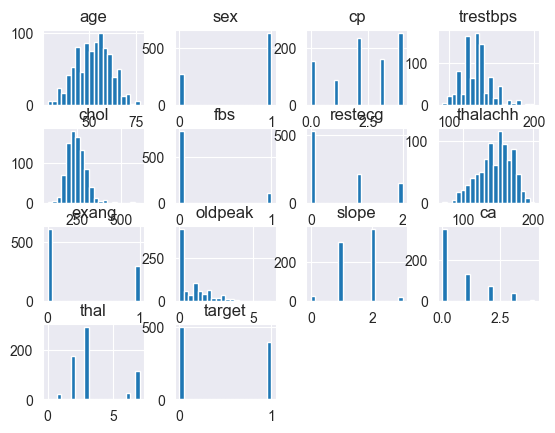

In [63]:
raw_dataset_.hist(bins = 20)

# Train_test_split

In [64]:
raw_dataset_nan = raw_dataset_.loc[ raw_dataset_.isna().sum(axis=1)>0 ]
raw_dataset_non_nan = raw_dataset_.loc[ raw_dataset_.isna().sum(axis=1)==0 ]


len(raw_dataset_nan), len(raw_dataset_non_nan)



(292, 602)

In [65]:
raw_dataset_nan["target"].mean(), raw_dataset_non_nan["target"].mean(), raw_dataset_["target"].mean()

(0.3595890410958904, 0.4850498338870432, 0.44407158836689037)

In [66]:
raw_dataset_non_nan, raw_dataset_test = train_test_split(raw_dataset_non_nan,stratify= raw_dataset_non_nan["target"] , test_size=100, random_state=42)
len(raw_dataset_non_nan), len(raw_dataset_test)

(502, 100)

In [67]:
raw_dataset_train = pd.concat([raw_dataset_nan, raw_dataset_non_nan], ignore_index=True)

In [68]:
raw_dataset_train.shape, raw_dataset_test.shape

((794, 14), (100, 14))

In [69]:
raw_dataset_train["target"].mean(), raw_dataset_test["target"].mean(), raw_dataset_["target"].mean()

(0.43828715365239296, 0.49, 0.44407158836689037)

# Neural Network - Useful Functions

In [70]:
class Net(nn.Module):
    def __init__(self, input_size, n_neurons, n_layers):
        super(Net, self).__init__()
        layers = []
        layers.append(nn.BatchNorm1d(input_size))

        if n_layers == 1:
            layers.append(nn.Linear(input_size, 1))
        else:
            layers.append(nn.Linear(input_size, n_neurons))
            layers.append(nn.ReLU())
            for _ in range(n_layers - 2):
                layers.append(nn.Linear(n_neurons, n_neurons))
                layers.append(nn.BatchNorm1d(n_neurons))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(n_neurons, 1))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)


    def forward(self, x):
        return self.model(x)



In [71]:
def train(model, train_loader, val_loader, epochs = 100, lr=0.001, scheduler_gamma=0.5):

    train_losses = []
    train_accuracies = []

    eval_losses = []
    eval_accuracies = []

    best_eval_acc = 0
    best_state = None

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=scheduler_gamma)
    criterion = nn.BCELoss()

    for epoch in range(epochs):

        print(epoch+1, '/', epochs, sep = '' , end=' ')

        model.train()
        train_loss = 0
        train_acc = 0
        for X, y in train_loader:

            optimizer.zero_grad()
            y_pred = model(X)

            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            acc = accuracy_score((y_pred>0.5).cpu().detach(), y.cpu())
            train_acc += acc


        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        train_acc /= len(train_loader)
        train_accuracies.append(train_acc)

        scheduler.step()
        print("Train loss:", train_loss, "| Train acc:", train_acc,  end=' ')


        model.eval()
        eval_loss = 0
        eval_acc = 0
        for X, y in val_loader:
            y_pred = model(X)

            loss = criterion(y_pred, y)
            eval_loss += loss.item()

            acc = accuracy_score((y_pred>0.5).cpu().detach(), y.cpu())
            eval_acc += acc

        eval_loss /= len(val_loader)
        eval_losses.append(eval_loss)

        eval_acc /= len(val_loader)
        eval_accuracies.append(eval_acc)


        print("Val loss: ", eval_loss, "| Val acc:", eval_acc)


        if eval_acc >= best_eval_acc:
            best_eval_acc = eval_acc
            best_state = deepcopy(model.state_dict())

    print("Best_eval acc:", best_eval_acc)
    return [train_losses, train_accuracies, eval_losses, eval_accuracies], best_state


In [72]:
def make_dataloader(my_clean_dataset):

    my_clean_dataset_train, my_clean_dataset_eval = train_test_split(my_clean_dataset, test_size=0.1,stratify=my_clean_dataset["target"] ,random_state=42)

    my_clean_dataset_train_dataset = TensorDataset(torch.Tensor( my_clean_dataset_train.drop(columns=["target"]).to_numpy() ).to(device),
                                                   torch.Tensor( my_clean_dataset_train["target"].to_numpy() ).unsqueeze(1).to(device)
                                                   )

    my_clean_dataset_eval_dataset = TensorDataset( torch.Tensor( my_clean_dataset_eval.drop(columns=["target"]).to_numpy() ).to(device),
                                                   torch.Tensor( my_clean_dataset_eval["target"].to_numpy() ).unsqueeze(1).to(device)
                                                   )

    my_clean_dataset_train_dataloader = DataLoader(my_clean_dataset_train_dataset, batch_size=64, shuffle=True)
    my_clean_dataset_eval_dataloader = DataLoader(my_clean_dataset_eval_dataset, batch_size=64, shuffle=False)

    return my_clean_dataset_train_dataloader, my_clean_dataset_eval_dataloader

# Imputing NaNs

In [73]:
imputer = SimpleImputer(strategy="median", fill_value=0)
my_imputed_dataset = imputer.fit_transform(raw_dataset_train)
my_imputed_dataset_test = raw_dataset_test.copy()

In [74]:
my_imputed_dataset = pd.DataFrame(my_imputed_dataset, columns=my_imputed_dataset_test.columns)
my_imputed_dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,28.0,1.0,2.0,130.0,132.0,0.0,2.0,185.0,0.0,0.0,2.0,0.0,3.0,0.0
1,29.0,1.0,2.0,120.0,243.0,0.0,0.0,160.0,0.0,0.0,2.0,0.0,3.0,0.0
2,29.0,1.0,2.0,140.0,244.0,0.0,0.0,170.0,0.0,0.0,2.0,0.0,3.0,0.0
3,30.0,0.0,1.0,170.0,237.0,0.0,1.0,170.0,0.0,0.0,2.0,0.0,6.0,0.0
4,31.0,0.0,2.0,100.0,219.0,0.0,1.0,150.0,0.0,0.0,2.0,0.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,54.0,1.0,0.0,110.0,239.0,0.0,1.0,126.0,1.0,2.8,1.0,1.0,3.0,0.0
790,54.0,1.0,2.0,150.0,232.0,0.0,0.0,165.0,0.0,1.6,2.0,0.0,3.0,1.0
791,41.0,1.0,3.0,112.0,250.0,0.0,0.0,179.0,0.0,0.0,1.0,0.0,3.0,0.0
792,66.0,1.0,4.0,112.0,212.0,0.0,2.0,132.0,1.0,0.1,1.0,1.0,3.0,1.0


In [75]:
for col in my_imputed_dataset.columns:
    if (my_imputed_dataset[col] % 1 == 0).all():
        my_imputed_dataset[col] = my_imputed_dataset[col].astype(int)
        my_imputed_dataset_test[col] = my_imputed_dataset_test[col].astype(int)

In [76]:
my_imputed_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       794 non-null    int64  
 1   sex       794 non-null    int64  
 2   cp        794 non-null    int64  
 3   trestbps  794 non-null    int64  
 4   chol      794 non-null    int64  
 5   fbs       794 non-null    int64  
 6   restecg   794 non-null    int64  
 7   thalachh  794 non-null    int64  
 8   exang     794 non-null    int64  
 9   oldpeak   794 non-null    float64
 10  slope     794 non-null    int64  
 11  ca        794 non-null    int64  
 12  thal      794 non-null    int64  
 13  target    794 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 87.0 KB


array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalachh'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'ca'}>],
       [<Axes: title={'center': 'thal'}>,
        <Axes: title={'center': 'target'}>, <Axes: >, <Axes: >]],
      dtype=object)

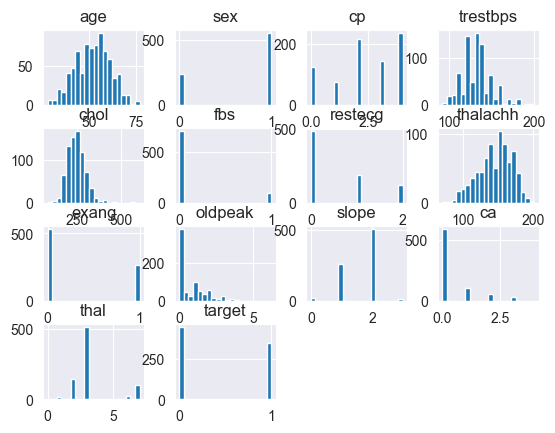

In [77]:
my_imputed_dataset.hist(bins = 20)

In [78]:
lambdas = {}

for col in ["thalachh", "oldpeak",  ]: # "age", "trestbps", "chol",
    my_imputed_dataset[col], boxcox_lambda = sp.stats.boxcox(my_imputed_dataset[col] + 1e-5, alpha=None, lmbda=None)
    lambdas[col] = boxcox_lambda
    my_imputed_dataset_test[col] = sp.stats.boxcox(my_imputed_dataset_test[col] + 1e-5, alpha=None, lmbda=lambdas[col])


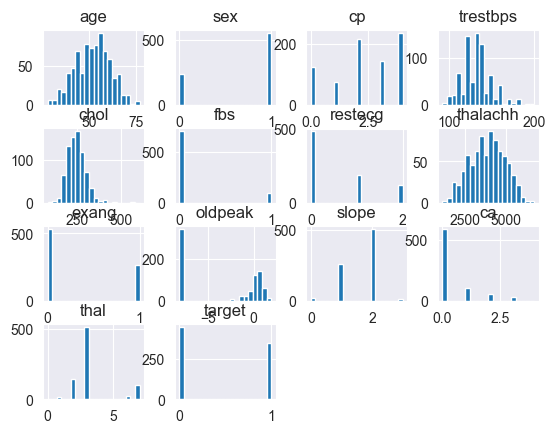

In [79]:
my_imputed_dataset.hist(bins = 20)
plt.show()

In [80]:
my_imputed_dataset.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.088150,-0.086861,0.237865,0.144113,0.163678,0.150259,-0.319800,0.143841,0.323457,-0.181044,0.371454,0.059336,0.064739
sex,-0.088150,1.000000,0.064000,0.012376,-0.109274,0.047848,-0.036561,-0.091475,0.140309,0.054029,0.010218,0.041910,0.150992,0.097314
cp,-0.086861,0.064000,1.000000,0.014910,0.059540,-0.011077,0.053172,-0.151548,0.068744,-0.012049,0.323391,-0.147814,0.425886,0.232680
trestbps,0.237865,0.012376,0.014910,1.000000,0.114105,0.138125,0.002906,-0.092300,0.119901,0.134633,-0.001266,0.067335,0.046628,0.039332
chol,0.144113,-0.109274,0.059540,0.114105,1.000000,0.019015,0.033997,-0.066599,0.108214,0.090247,0.003190,0.070478,0.041235,0.094456
fbs,0.163678,0.047848,-0.011077,0.138125,0.019015,1.000000,0.037485,0.017107,0.027761,0.065287,-0.061633,0.148993,0.002630,0.062105
restecg,0.150259,-0.036561,0.053172,0.002906,0.033997,0.037485,1.000000,0.034810,0.069334,0.106266,-0.020821,0.164142,0.156900,0.123553
thalachh,-0.319800,-0.091475,-0.151548,-0.092300,-0.066599,0.017107,0.034810,1.000000,-0.369280,-0.286146,-0.065299,-0.083306,-0.110607,-0.063674
exang,0.143841,0.140309,0.068744,0.119901,0.108214,0.027761,0.069334,-0.369280,1.000000,0.387460,-0.009034,0.113981,0.152519,0.195541
oldpeak,0.323457,0.054029,-0.012049,0.134633,0.090247,0.065287,0.106266,-0.286146,0.387460,1.000000,-0.206511,0.220054,0.149792,0.211434


age 47
sex 2
cp 5
trestbps 54
chol 201
fbs 2
restecg 3
thalachh 103
exang 2
oldpeak 41
slope 4
ca 5
thal 6


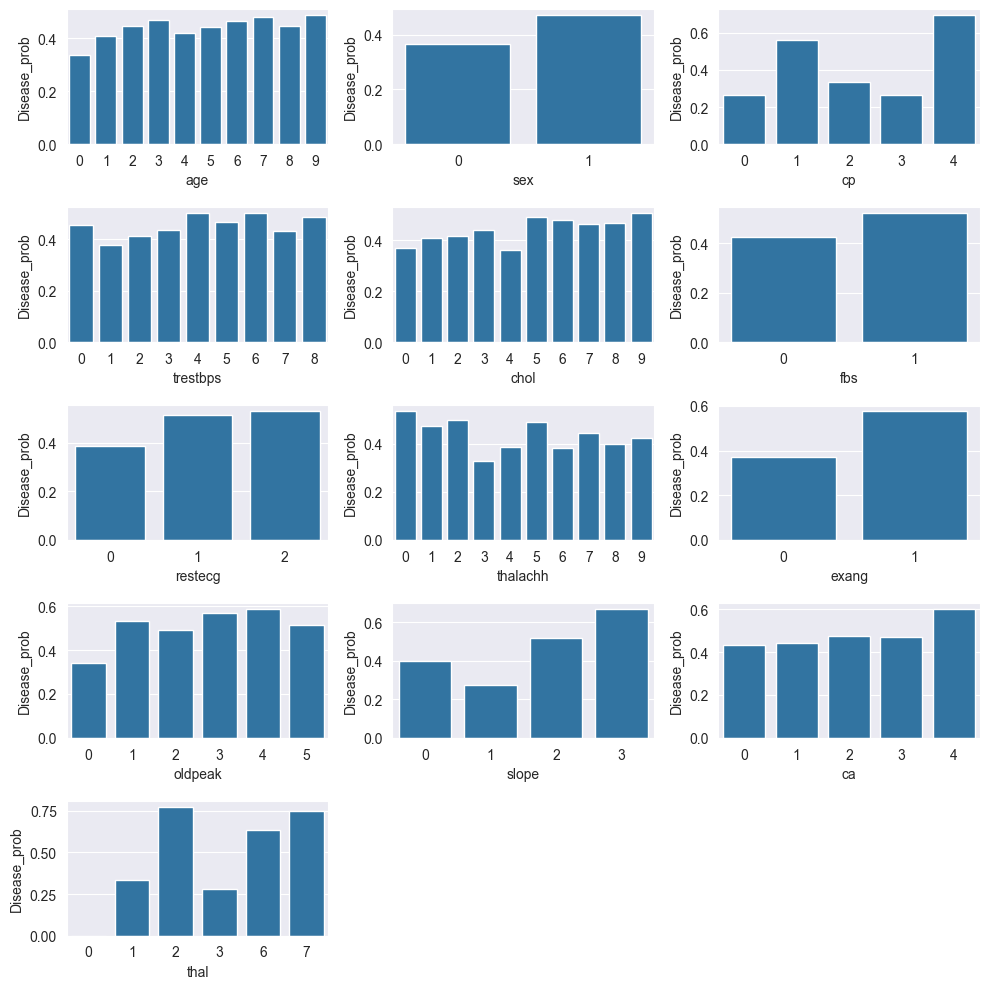

In [81]:
plot_proba(my_imputed_dataset)

### XGBoost

In [82]:
xgb_model = XGBClassifier( learning_rate=0.001,
                           max_depth=3,
                           n_estimators=1000,
                           subsample=0.5,
                           colsample_bytree=0.7,
                           # gamma=1,
                           # reg_alpha=0.5,
                           # reg_lambda=0.5,
                           seed=42)


cross_val_score(xgb_model,
                my_imputed_dataset.drop(columns=["target"]),
                my_imputed_dataset["target"],
                cv=5).mean()

0.8148316216861714

In [83]:
xgb_model.fit(my_imputed_dataset.drop(columns=["target"]),
              my_imputed_dataset["target"],
              verbose=True)

y_train_pred = xgb_model.predict(my_imputed_dataset.drop(columns=["target"]))
print("Train_acc:", accuracy_score(my_imputed_dataset["target"], y_train_pred))
print("Train_f1: ", f1_score(my_imputed_dataset["target"], y_train_pred))


y_test_pred = xgb_model.predict(my_imputed_dataset_test.drop(columns=["target"]))
print("Test_acc: ", accuracy_score(my_imputed_dataset_test["target"], y_test_pred))
print("Test_f1:  ", f1_score(my_imputed_dataset_test["target"], y_test_pred))

Train_acc: 0.8387909319899244
Train_f1:  0.8006230529595015
Test_acc:  0.8
Test_f1:   0.782608695652174


### Neural Network

In [84]:
my_imputed_dataset_train_dataloader , my_imputed_dataset_eval_dataloader = make_dataloader(my_imputed_dataset)

In [90]:

my_imputed_model = Net(input_size= len(my_imputed_dataset.columns)-1,
                     n_neurons=14,
                     n_layers=3,
                     ).to(device)



my_imputed_losses , my_imputed_state_dict = train(my_imputed_model,
                                             my_imputed_dataset_train_dataloader,
                                             my_imputed_dataset_eval_dataloader,
                                             epochs = 300, lr=0.01, scheduler_gamma=0.5
                                             )

1/300 Train loss: 0.6124484241008759 | Train acc: 0.6895833333333333 Val loss:  0.6537112891674042 | Val acc: 0.5546875
2/300 Train loss: 0.5505827615658442 | Train acc: 0.7158854166666666 Val loss:  0.5274604856967926 | Val acc: 0.7421875
3/300 Train loss: 0.5254764432708422 | Train acc: 0.7276041666666666 Val loss:  0.491566002368927 | Val acc: 0.6796875
4/300 Train loss: 0.48961469531059265 | Train acc: 0.7296874999999999 Val loss:  0.4907972514629364 | Val acc: 0.765625
5/300 Train loss: 0.48368903001149494 | Train acc: 0.7846354166666667 Val loss:  0.4286476671695709 | Val acc: 0.8359375
6/300 Train loss: 0.4596511150399844 | Train acc: 0.7919270833333334 Val loss:  0.44687147438526154 | Val acc: 0.828125
7/300 Train loss: 0.44788961857557297 | Train acc: 0.7880208333333334 Val loss:  0.4317956417798996 | Val acc: 0.8203125
8/300 Train loss: 0.46716655790805817 | Train acc: 0.7807291666666667 Val loss:  0.532454714179039 | Val acc: 0.7421875
9/300 Train loss: 0.6044738392035166 | 

In [91]:

my_imputed_model.eval()
my_imputed_model.to("cpu")

y_train_pred = my_imputed_model( torch.Tensor(my_imputed_dataset.drop(columns=["target"]).to_numpy())).detach() > 0.5
print("Train_acc:", accuracy_score(my_imputed_dataset["target"], y_train_pred))
print("Train_f1: ", f1_score(my_imputed_dataset["target"], y_train_pred))


y_test_pred = my_imputed_model( torch.Tensor(my_imputed_dataset_test.drop(columns=["target"]).to_numpy())).detach() > 0.5
print("Test_acc: ", accuracy_score(my_imputed_dataset_test["target"], y_test_pred))
print("Test_f1:  ", f1_score(my_imputed_dataset_test["target"], y_test_pred))


Train_acc: 0.8929471032745592
Train_f1:  0.8773448773448773
Test_acc:  0.83
Test_f1:   0.8282828282828283


In [92]:
print(confusion_matrix(my_imputed_dataset_test["target"], y_test_pred))

[[42  9]
 [ 8 41]]
